# Training model for pneumothorax segmentation task
- ## Classification model ( Part 1 )

In this challenge, we observed heavy imbalance of data between positive and negative cases. Hence we decided to split out detection algorithm into 2 stages. <br>
For stage 1, images are passed into the classification model to determine if they are diagnosed with pneumothorax. <br>
This is because if we leave all learnings to the segmentation model will be expected to be too heavy for small dataset with sparse observation. <br>
Then, for all samples diagosed by our machine with positive labels, they will be sent to generate the segmentation map in stage 2. <br>
Details for stage 2 will be shared in part 2 of separate kernel.

As for the strategy for part 1, we trained 3 models to predict the class of pneumothorax case <br>
Additionally, we exploit the discussion posted by Dr. Konya given 1000 hand drawn bounding boxes to train a faster RCNN to quickly learn the bounding boxes of the rest. <br>
We hypothesize that cropping more regional/focused image increases the resolution of the input and model can learn better.
Lastly, we ensemble these 3 models to get final results.

- Our classification models are namely as follows:
>1. Efficient model (with bounding boxes)
>2. Xception model (with bounding boxes)
>3. Efficient model (without)


In [1]:
import tensorflow as tf
from dataPipeline_class import *
from model_metrics import *
from model_utils import *
import glob as glob
import os as os
import keras
import seaborn as sns

# Configure GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = '3' # uncheck to select multi gpu
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess=tf.Session(config = config)

num_classes = 1
batch_size = 28
img_sz = 512

Using TensorFlow backend.


Importing data and setting up data path for training
- we used small sample of NIH negatives and positives to augment our training data

In [2]:
# data path
imgs_train, imgs_valid, label_train, label_valid = split_datalist(split_ratio=0.8)
nih_train = glob.glob('./nih_kaggle_training/*')
nih_train.sort()

# load labels nih
nih_labs = pd.read_csv('./nih_kaggle_training.csv')
nih_labs = nih_labs.sort_values(by='filename')


posNIH = [os.path.join('./nih_kaggle_training/', fname) for fname in nih_labs.filename[nih_labs.labels == 1]]
negNIH = list(set(nih_train)- set(posNIH))

train_kaggle_pos = []
for i,lab in enumerate(np.bool8(label_train[:,1])):
    if lab == True:
        train_kaggle_pos.append(imgs_train[i])
train_kaggle_neg = list(set(imgs_train) - set(train_kaggle_pos))

train_pos = train_kaggle_pos + posNIH
train_neg = train_kaggle_neg + negNIH
train_imgs = train_pos+train_neg

poslabs = np.float32([[0.,1.]]*len(train_pos))
neglabs = np.float32([[1.,0.]]*len(train_neg))

train_imgs = train_pos+train_neg
train_labs = np.concatenate([poslabs,neglabs])

# make generator
train_generator = create_generators(image_path=train_imgs, label_path=train_labs, 
                                    n_classes = num_classes, batch_size = batch_size, 
                                    resize_shape=(img_sz,img_sz), elastic_transform = False, seed=609, 
                                    crop_shape = False, horizontal_flip = True,
                                    blur = False, vertical_flip = False,
                                    brightness=True, rotation=2.0,
                                    zoom=False, do_ahisteq = True, bbox= False)

valid_generator = create_generators(image_path=imgs_valid, label_path=label_valid, 
                                    n_classes = num_classes, batch_size = batch_size, 
                                    resize_shape=(img_sz,img_sz), elastic_transform = False, seed=610,
                                    crop_shape = False, horizontal_flip = False,
                                    blur = False, vertical_flip = False,
                                    brightness=True, rotation=2.0,
                                    zoom=False, do_ahisteq = True, bbox= False)

### Visualising generator with augmentation

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

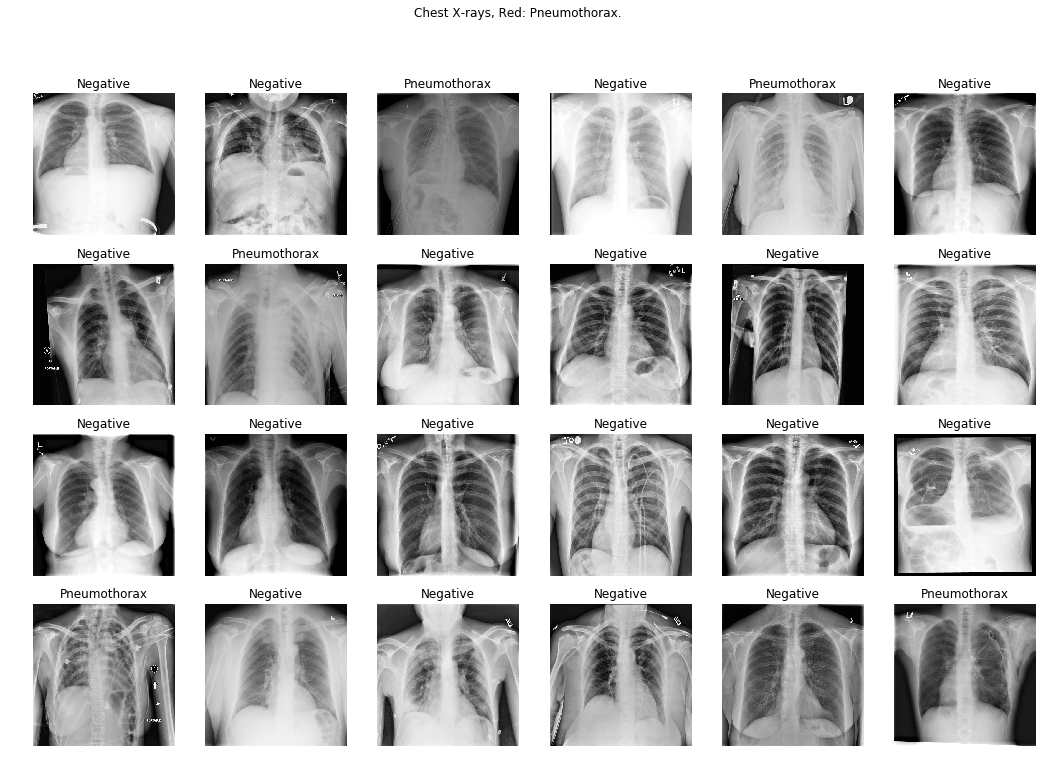

In [3]:
# Visualisation of augmented generator
images, labels = train_generator.__getitem__(0)
labels = np.argmax(labels, axis=1)
labels = ['Pneumothorax' if i else 'Negative' for i in labels]

max_images = 24
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i, (im,label) in enumerate(zip(images[:max_images], labels[:max_images])):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="gray")
    ax.set_title(label)
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

- ### Defining our models

In [4]:
from keras.applications.xception import Xception
from efficientnet import EfficientNetB4
from keras.layers import Dense, Input
from keras.models import Model
from keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import BatchNormalization, Dropout, Add
from keras.layers import LeakyReLU, MaxPooling2D, GlobalAveragePooling2D


def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# ~~~~~~~~~~ Efficient model ~~~~~~~~~~~~~~~
def EfficientNet_model(input_shape=(None, None, 3),
                       num_classes=1, weight = 'imagenet',
                       dropout_rate=0.5):

    backbone = EfficientNetB4(weights=weight,
                              include_top=False,
                              input_shape=input_shape)
    
    img_input = backbone.input

    x = backbone.layers[342].output # consider 257, 154
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(960, (3, 3), activation=None, padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(960, (3, 3), activation=None, padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    
    if num_classes == 1:
        predictions=Dense(num_classes+1, activation='sigmoid', name='predictions')(x)
    else:
        predictions=Dense(num_classes+1, activation='softmax', name='predictions')(x)
        
    model = Model(inputs=img_input, outputs=predictions)
    if weight is not 'imagenet' and not None:
        print('loading model weights from pretrained...')
        model.load_weights(weight)
    return model

# ~~~~~~~~~~ Xception model ~~~~~~~~~~~~~~~
def xception_model(input_shape, num_classes, weight='imagenet'):
    img_input = Input(shape=input_shape)
    backbone = Xception(weights=weight,
                        include_top=False,
                        input_tensor=img_input,
                        input_shape=input_shape,
                        pooling='avg')
    
    x = backbone.layers[103].output # 103
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(960, (3, 3), activation=None, padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(960, (3, 3), activation=None, padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    
    if num_classes == 1:
        predictions=Dense(num_classes+1, activation='softmax', name='predictions')(x)
    else:
        predictions=Dense(num_classes+1, activation='softmax', name='predictions')(x)
        
    model = Model(inputs=img_input, outputs=predictions)
    if weight is not 'imagenet' and not None:
        print('loading model weights from pretrained...')
        model.load_weights(weight)
    return model


# ~~~~~~~~~~ Enable multi GPU training ~~~~~~~~~~~~~~~
from keras.utils import multi_gpu_model
class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
           serial-model holds references to the weights in the multi-gpu model.
           '''
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)
        else:
            #return Model.__getattribute__(self, attrname)
            return super(ModelMGPU, self).__getattribute__(attrname)
        

        
# assign models
tf.set_random_seed(123)
keras.backend.clear_session()

# Xception model with cropped
model1 = xception_model(input_shape=(img_sz,img_sz,3), 
                        num_classes= 1,
                        weight= 'imagenet')

# Efficient model with cropped
model2 = EfficientNet_model(input_shape=(img_sz,img_sz,3), 
                            num_classes= 1,
                            weight= 'imagenet')

# Efficient model without cropped
model3 = EfficientNet_model(input_shape=(img_sz,img_sz,3), 
                            num_classes= 1,
                            weight= 'imagenet')

# Edit here to enable multi-gpu training
model3 = ModelMGPU(model3, 4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [5]:
# define callbacks
epochs = 30
# Learning rate
init_lr = 3e-4  # efficient(3e-4) # xception(3e-5)
# Model Metrics
metrics = ['acc']
# Define loss-binary cross entropy
loss = 'weighted_bce'

from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, CSVLogger, EarlyStopping

# callbacks params and configs
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):
        
        # Save checkpoint
        path = os.path.join(root_dir, 'stack_class')
        filepath = os.path.join(path,'improved_weights_{epoch:02d}_{val_binary_accuracy:.2f}.hdf5')
        checkpointer = ModelCheckpoint(filepath = filepath, verbose=1, save_best_only=True,
                                       save_weights_only=True, monitor = 'val_binary_accuracy', mode = 'max')

        # early stoppage
        stop_train = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, verbose=1, mode = 'min')
        
        # reduce learning rate scheduling
        #schedule_lr = LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        schedule_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode = 'min', patience=1, min_lr=1e-9, cooldown=1)
        
        # CSV logger
        logger = CSVLogger(os.path.join(path,'training_log.csv'))

        # design callbacks
        callback_list = [schedule_lr, stop_train, checkpointer, logger]
        
        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M)) # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        lr= float(self.alpha_zero / 2 * cos_out)
        
        # reduce learning rate as training progress 
        if t>5 and not t%5:
            self.alpha_zero *= 0.5
            
        return lr

callbacks = SnapshotCallbackBuilder(nb_epochs=epochs, 
                                    nb_snapshots=1,
                                    init_lr=init_lr)

In [6]:
# Run this cell to train individual model.
# compile model here before training
compile_model(model3, num_classes, metrics, loss, init_lr)
# Fit models (Train model here)
train_with_generator(model=model3, epochs=epochs, train_generator=train_generator,
                     valid_generator= valid_generator, callbacks= callbacks.get_callbacks(),
                     class_weights=None, mp = False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
736/736 [==============================] - 716s 973ms/step - loss: 0.5431 - binary_accuracy: 0.8214 - val_loss: 0.3743 - val_binary_accuracy: 0.8842

Epoch 00001: val_binary_accuracy improved from -inf to 0.88416, saving model to /data/volume03/SIIM_ACR/checkpoints_efficient2/improved_weights_01_0.88.hdf5
Epoch 2/30
736/736 [==============================] - 649s 882ms/step - loss: 0.3938 - binary_accuracy: 0.8733 - val_loss: 0.4797 - val_binary_accuracy: 0.8600

Epoch 00002: val_binary_accuracy did not improve from 0.88416
Epoch 3/30
736/736 [==============================] - 651s 885ms/step - loss: 0.3111 - binary_accuracy: 0.9045 - val_loss: 0.6054 - val_binary_accuracy: 0.8588

Epoch 00003: val_binary_accuracy did not improve from 0.88416
Epoch 4/30
736/736 [==============================] - 653s 887ms/step - loss: 0.2443 - binary_accuracy: 0.9266 - val_loss: 0.4609 - val_binary_accuracy: 0.8611

Epoch 00004: val_binary_acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



736/736 [==============================] - 658s 894ms/step - loss: 0.1527 - binary_accuracy: 0.9555 - val_loss: 0.5116 - val_binary_accuracy: 0.8715

Epoch 00016: val_binary_accuracy did not improve from 0.88416
Epoch 17/30
736/736 [==============================] - 661s 898ms/step - loss: 0.1516 - binary_accuracy: 0.9565 - val_loss: 0.4917 - val_binary_accuracy: 0.8717

Epoch 00017: val_binary_accuracy did not improve from 0.88416
Epoch 18/30
736/736 [==============================] - 661s 898ms/step - loss: 0.1508 - binary_accuracy: 0.9568 - val_loss: 0.5037 - val_binary_accuracy: 0.8680

Epoch 00018: val_binary_accuracy did not improve from 0.88416
Epoch 19/30
736/736 [==============================] - 660s 897ms/step - loss: 0.1514 - binary_accuracy: 0.9560 - val_loss: 0.5083 - val_binary_accuracy: 0.8675

Epoch 00019: val_binary_accuracy did not improve from 0.88416
Epoch 20/30
359/736 [=============>................] - ETA: 5:29 - loss: 0.1434 - binary_accuracy: 0.9582

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Ensembling our classification models
We have trained our models and the weights are saved in the folder.
- import weights to our models to implement ensembling.

In [6]:
model1.load_weights('./saved_weights/classification/xception_class.hdf5')
model2.load_weights('./saved_weights/classification/efficient_cropped.hdf5')
model3.load_weights('./saved_weights/classification/efficient_nocrop.hdf5')

candidates = [model1,model2,model3]

In [7]:
# stacked generalization with neural net meta model 
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
            
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(28, activation='relu')(merge)
    output = Dense(2, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)

    return model

stacked_model = define_stacked_model(candidates)
# stacked_model = ModelMGPU(stacked_model, 4) # uncheck to use multi GPU training

In [8]:
num_model = 3
train_stackgenerator = create_generators(image_path=train_imgs, label_path=train_labs, 
                                        n_classes = num_classes, batch_size = batch_size, 
                                        resize_shape=(img_sz,img_sz), elastic_transform = False, seed=609, 
                                        crop_shape = False, horizontal_flip = True,
                                        blur = False, vertical_flip = False,
                                        brightness=True, rotation=2.0,
                                        zoom=False, do_ahisteq = True, ensemble=num_model)

valid_stackgenerator = create_generators(image_path=imgs_valid, label_path=label_valid, 
                                        n_classes = num_classes, batch_size = batch_size, 
                                        resize_shape=(img_sz,img_sz), elastic_transform = False, seed=610,
                                        crop_shape = False, horizontal_flip = False,
                                        blur = False, vertical_flip = False,
                                        brightness=True, rotation=2.0,
                                        zoom=False, do_ahisteq = True, ensemble=num_model)


compile_model(stacked_model, num_classes, metrics, loss, init_lr)
train_with_generator(model=stacked_model, epochs=epochs, train_generator=train_stackgenerator,
                     valid_generator= valid_stackgenerator, callbacks= callbacks.get_callbacks(),
                     class_weights=None, mp = False)

In [9]:
stacked_model.load_weights('./saved_weights/classification/stack_model.hdf5')

In [10]:
testing_generator = create_generators(image_path=imgs_valid, label_path=label_valid, 
                                        n_classes = num_classes, batch_size = len(label_valid), 
                                        resize_shape=(512,512), elastic_transform = False, seed=610,
                                        crop_shape = False, horizontal_flip = False,
                                        blur = False, vertical_flip = False,
                                        brightness=True, rotation=False,
                                        zoom=False, do_ahisteq = True, bbox=True, ensemble=num_model)

In [11]:
test_imgs, target_masks = testing_generator.__getitem__(0)
pred_mask = stacked_model.predict(test_imgs)
pred_mask2 = np.argmax(pred_mask,axis=1)
target_masks2 = np.argmax(target_masks, axis=1)

Confusion matrix, without normalization
[[1527  140]
 [  76  392]]
sensitivity:  0.8376068376068376
specificity:  0.9160167966406718
accuracy of the model:  0.8988290398126464


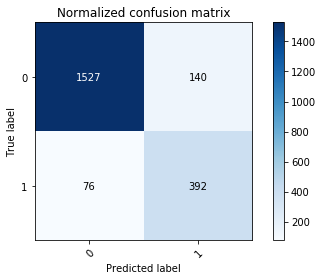

In [12]:
confusion_mat, x = plot_confusion_matrix(target_masks2, np.int8(pred_mask[:,0]<= 0.50), normalize=False,
                                        title='Normalized confusion matrix')
acc = 1- (x[0,1] + x[1,0])/ len(label_valid)
print('accuracy of the model: ', acc)

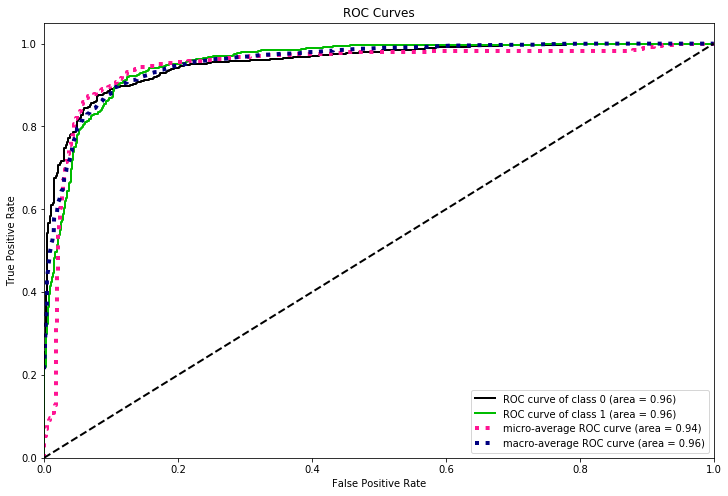

In [15]:
import scikitplot as skplt
skplt.metrics.plot_roc(target_masks2, pred_mask, figsize=(12,8))

### Generating class labels

In [9]:
bounding_box1 = pd.read_csv('./boundingbox_csv/siim_pneumothorax_train_bb.csv') 
bounding_box2 = pd.read_csv('./boundingbox_csv/nih_train_bb.csv')
bounding_box3 = pd.read_csv('./boundingbox_csv/siim_pneumothorax_test_bb.csv')
bounding_box4 = pd.read_csv('./boundingbox_csv/stage2bb.csv')

bbox_total = pd.concat([bounding_box1, bounding_box2, bounding_box3, bounding_box4])

def make_crop_box(image, image_path):
    if np.random.uniform() < 0.8:
        filename = basename(image_path)
        box_coord = bbox_total.loc[bbox_total.filename == filename]
        img = image[int(box_coord.ymin):int(box_coord.ymax), int(box_coord.xmin):int(box_coord.xmax)]
    else:
        img = image
    return img

In [10]:
# Predict testing set
from glob import glob
test_fn = glob('./stage2/*')
x_test = [cv2.resize(make_crop_box(plt.imread(fn),fn),(512,512)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test = stacked_model.predict([x_test,x_test,x_test])

from os.path import basename, splitext
fnames = [basename(img) for img in test_fn]
table_test = pd.DataFrame()
table_test['image'] = fnames
table_test['class_prob'] = 1- preds_test[:,0]
table_test['label'] = np.int8(preds_test[:,0]<= 0.55) # 0.62
table_test.to_csv('stackclass_label2.csv', index=False)

(3205, 512, 512, 3)


In [12]:
table_test.label.value_counts()

0    2428
1     777
Name: label, dtype: int64